# Converting a simple NetCDF file to a TileDB group or array

## About this Example

### What it Shows

The purpose of this example is to show the basics of converting a NetCDF file to a TileDB group or array.

This includes:

1. Options for auto-generating a converter from a NetCDF file.
2. Changing the TileDB schema settings before conversion.
3. Creating the TileDB group and copying data from the NetCDF file to the TileDB array.

### Set-up Requirements

This example requires the following python packages are installed: netCDF4, numpy, tiledb, tiledb-cf, and matplotlib


In [1]:
import tiledb
import tiledb.cf

import netCDF4
import numpy as np

import matplotlib.pyplot as plt

netcdf_file = "temp/simple1.nc"
group_uri = "arrays/simple_netcdf_to_group_1"
array_uri = "arrays/simple_netcdf_to_array_1"

In [2]:
from tiledb.cf.netcdf_engine._utils import COORDINATE_SUFFIX

print(COORDINATE_SUFFIX)

.data


In [3]:
import shutil

# clean up any previous runs
try:
    shutil.rmtree(group_uri)
    shutil.rmtree(array_uri)
except:
    pass

## Create an example NetCDF file

If the NetCDF file does not exist, we create a small NetCDF file for this example. 

### Example dataset

This example shows convertering a small NetCDF file with 2 dimensions and 4 variables:

* Dimensions:
    * x: size=100
    * y: size=100
* Variables:
    * x(x)
        * description: evenly spaced values from -5 to 5
        * data type: 64-bit floating point
    * y(x)
        * description: evenly spaced values from -5 to 5
        * data type: 64-bit floating point
    * A1(x, y)
        * description: x + y
        * data type: 64-bit floating point
    * A1(x, y)
        * description: sin((x/2)^2 + y^2
        * data type: 64-bit floating point

In [4]:
vfs = tiledb.VFS()
if not vfs.is_file(netcdf_file):
    x_data = np.linspace(-5.0, 5.0, 100)
    y_data = np.linspace(-5.0, 5.0, 100)
    xv, yv = np.meshgrid(x_data, y_data, sparse=True)
    with netCDF4.Dataset(netcdf_file, mode="w") as dataset:
        dataset.setncatts({"title": "Simple dataset for examples"})
        dataset.createDimension("x", 100)
        dataset.createDimension("y", 100)
        A1 = dataset.createVariable("A1", np.float64, ("x", "y"))
        A1.setncattr("full_name", "Example matrix A1")
        A1.setncattr("description", "x + y")
        A1[:, :] = xv + yv
        A2 = dataset.createVariable("A2", np.float64, ("x", "y"))
        A2[:, :] = np.sin((xv / 2.0) ** 2 + yv ** 2)
        A2.setncattr("full_name", "Example matrix A2")
        A2.setncattr("description", "sin((x/2)^2 + y^2")
        x1 = dataset.createVariable("x", np.float64, ("x",))
        x1[:] = x_data
        y = dataset.createVariable("y", np.float64, ("y",))
        y[:] = y_data
    print(f"Created example NetCDF file `{netcdf_file}`.")
else:
    print(f"Example NetCDF file `{netcdf_file}` already exists.")


Example NetCDF file `temp/simple1.nc` already exists.


## Auto-Generating Converter from File

The `NetCDF4ConverterEngine.from_file` and `NetCDF4ConverterEngine.from_group` are used to auto-generate a NetCDF-to-TileDB conversion recipe.



Parameters:

* Set the location of the NetCDF group to be converted.

    * `from_file`: 

        * `input_file`: The input NetCDF file to generate the converter engine from.
        * `group_path`: The path to the NetCDF group to copy data from. Use `'/'` for the root group.
    
    * `from_group`:
        
        * `input_group`

* Set the array grouping. A NetCDF variable maps to TileDB attributes. The `collect_attrs` parameters determines if each NetCDF variable is stored in a separate array, or if all NetCDF variables with the same underlying dimensions are stored in the same TileDB array. Scalar variables are always grouped together.

    * `collect_attrs`: If `True`, store all attributes with the same dimensions in the same array. Otherwise, store each attribute in a separate array.

* Set default properties for TileDB dimension. 

    * `unlimited_dim_size`: The default size of the domain for TileDB dimensions created from unlimited NetCDF dimensions. If `None`, the current size of the NetCDF dimension will be used.
    * `dim_dtype`: The default numpy dtype to use when converting a NetCDF dimension to a TileDB dimension.

* Set tile sizes for TileDB dimensions. Multiple arrays in the TileDB group may have the same name, domain, and type, but different tiles and compression filters. The `tiles_by_var` and `tiles_by_dims` parameters allow a way of setting the tiles for the dimensions in different arrays. The `tiles_by_var` parameter is a mapping from variable name to the tiles for the dimensions of the array that variable is stored in. The `tiles_by_dims` parameter is a mapping from the names of the dimensions of the array to the tiles for the dimensions of the array. If using `collect_attrs=True`, then `tiles_by_dims` will over-write `tiles_by_var`. If using `collect_attrs=False`, then `tiles_by_vars` with over-write `tiles_by_var`.

    * `tiles_by_var`: A map from the name of a NetCDF variable to the tiles of the dimensions of the variable in the generated TileDB array.
    * `tiles_by_dims`: A map from the name of NetCDF dimensions defining a variable to the tiles of those dimensions in the generated TileDB array.

* Convert 1D variables with the same name and dimension to a TileDB dimension instead of a TileDB attribute.

    * `coords_to_dims`: If `True`, convert the NetCDF coordinate variable into a TileDB dimension for sparse arrays. Otherwise, convert the coordinate dimension into a TileDB dimension and the coordinate variable into a TileDB attribute.

### Examples: Collecting attributes and setting tiles

Below are some examples of how the parameter `collect_attrs`, `tiles_by_var`, and `tiles_by_dims` interact.

1. `collect_attrs=True`
    * `A1` and `A2` are in the same array.
    * `tile=None` for all dimensions.
2. `collect_attrs=True`, `tiles_by_dims={(x,y): (10, 20)}`
    * `A1` and `A2` are in the same array.
    * Only array with dimensions `(x,y)` has tiles set.
3. `collect_attrs=True`, `tiles_by_var={'A1': (50, 50)}`
    * `A1` and `A2` are in the same array.
    * Only array with variable `A1` has tiles set.
4. `collect_attrs=True`, `tiles_by_dims={(x,y): (10, 20)}`, `tiles_by_var={'A1': (50, 50)}`
    * `A1` and `A2` are in the same array.
    * Only array with dimensions `(x,y)` has tiles set. `tiles_by_dims` wrote over `tiles_by_var`.
5. `collect_attrs=False`
    * `A1` and `A2` are in separate arrays.
    * `tile=None` for all dimensions.
6. `collect_attrs=False`, `tiles_by_dims={(x,y): (10, 20)}`
    * `A1` and `A2` are in separate arrays.
    * Only arrays with dimensions `(x,y)` have tiles set.
7. `collect_attrs=False`, `tiles_by_var={'A1': (50, 50)}`
    * `A1` and `A2` are in separate arrays.
    * Only array with variable `A1` has tiles set.
8. `collect_attrs=False`, `tiles_by_dims={(x,y): (10, 20)}`, `tiles_by_var={'A1': (50, 50)}`
    * `A1` and `A2` are in separate arrays.
    * The array with `A2` has tiles set by `tiles_by_dims`.
    * The array with `A1` has tiles set with `tiles_by_var` writing over `tiles_by_dims`. 

In [5]:
# Change the parameter values and see how it effects the tile value in the DimensionCreators (inside ArrayCreators)
tiledb.cf.NetCDF4ConverterEngine.from_file(netcdf_file, collect_attrs=True, tiles_by_dims=None, tiles_by_var=None)

"NetCDFDimension(name=x, size=100) → SharedDim(name=x, domain=(0, 99), dtype='uint64')"
"NetCDFDimension(name=y, size=100) → SharedDim(name=y, domain=(0, 99), dtype='uint64')"
"NetCDFDimension(name=x, size=100) → tiledb.Dim(name=x, domain=(0, 99), dtype='uint64', tile=None)"
"→ tiledb.Attr(name=x.data, dtype='float64', var=False, nullable=False)"
cell_order=row-major
tile_order=row-major
capacity=0
sparse=False
coords_filters=None
"NetCDFDimension(name=x, size=100) → tiledb.Dim(name=x, domain=(0, 99), dtype='uint64', tile=None)"
"NetCDFDimension(name=y, size=100) → tiledb.Dim(name=y, domain=(0, 99), dtype='uint64', tile=None)"


## Convert `simple1.nc` to a TileDB Group

In this example, we create a NetCDF4ConverterEngine from the NetCDF file and manually change properties of the TileDB arrays before conversion. NetCDF dimensions are mapped to TileDB dimensions, and NetCDF variables are mapped to TileDB attributes.

In [6]:
converter = tiledb.cf.NetCDF4ConverterEngine.from_file(netcdf_file, collect_attrs=True, dim_dtype=np.uint32)
converter

"NetCDFDimension(name=x, size=100) → SharedDim(name=x, domain=(0, 99), dtype='uint32')"
"NetCDFDimension(name=y, size=100) → SharedDim(name=y, domain=(0, 99), dtype='uint32')"
"NetCDFDimension(name=x, size=100) → tiledb.Dim(name=x, domain=(0, 99), dtype='uint32', tile=None)"
"→ tiledb.Attr(name=x.data, dtype='float64', var=False, nullable=False)"
cell_order=row-major
tile_order=row-major
capacity=0
sparse=False
coords_filters=None
"NetCDFDimension(name=x, size=100) → tiledb.Dim(name=x, domain=(0, 99), dtype='uint32', tile=None)"
"NetCDFDimension(name=y, size=100) → tiledb.Dim(name=y, domain=(0, 99), dtype='uint32', tile=None)"


In [7]:
# Update properties manually by modifying the array creators
# Update properties for array of matrices
data_array = converter.get_array_creator_by_attr("A1")
data_array.name = "data"
data_array.domain_creator.tiles = (20, 20)
for attr_creator in data_array:
    attr_creator.filters = tiledb.FilterList([tiledb.ZstdFilter()])
converter

"NetCDFDimension(name=x, size=100) → SharedDim(name=x, domain=(0, 99), dtype='uint32')"
"NetCDFDimension(name=y, size=100) → SharedDim(name=y, domain=(0, 99), dtype='uint32')"
"NetCDFDimension(name=x, size=100) → tiledb.Dim(name=x, domain=(0, 99), dtype='uint32', tile=None)"
"→ tiledb.Attr(name=x.data, dtype='float64', var=False, nullable=False)"
cell_order=row-major
tile_order=row-major
capacity=0
sparse=False
coords_filters=None
"NetCDFDimension(name=y, size=100) → tiledb.Dim(name=y, domain=(0, 99), dtype='uint32', tile=None)"
"→ tiledb.Attr(name=y.data, dtype='float64', var=False, nullable=False)"


In [8]:
# Update properties for the array containing "x.data"


In [9]:
# Update properties for the array containing "y.data"


Run the conversions to create two dense TileDB arrays:

In [10]:
converter.convert_to_group(group_uri)

### Examine the TileDB group schema

In [11]:
group_schema = tiledb.cf.GroupSchema.load(group_uri)
group_schema

"Dim(name='dim', domain=(0, 0), tile='1', dtype='int32')"
"Attr(name='attr', dtype='int32', var=False, nullable=False)"
cell_order=row-major
tile_order=row-major
capacity=10000
sparse=False
coords_filters=FilterList([ZstdFilter(level=-1)])
"Dim(name='x', domain=(0, 99), tile='100', dtype='uint32')"
"Attr(name='x.data', dtype='float64', var=False, nullable=False)"
cell_order=row-major
tile_order=row-major


### Examine the data in the arrays

Open the attributes from the generated TileDB group:

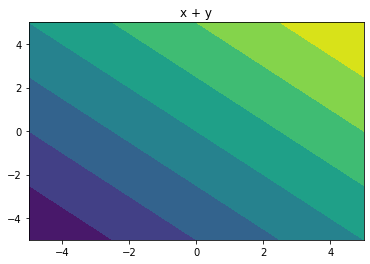

In [12]:
with tiledb.cf.Group(group_uri, attr="x.data") as group:
    with (
        group.open_array(attr="x.data") as x_array,
        group.open_array(attr="y.data") as y_array,
        group.open_array(array="data") as data_array,
    ):
        x = x_array[:]
        y = y_array[:]
        data = data_array[...]
        A1 = data["A1"]
        a1_description = tiledb.cf.AttrMetadata(data_array.meta, "A1")["description"]
fig, axes = plt.subplots(nrows=1, ncols=1)
axes.contourf(x, y, A1);
axes.set_title(a1_description);

In [13]:
# Plot A2 over -1 <= x <= 1 and 0 <= y < 2 by only querying on those regions

## Convert `simple1.nc` to a Single Sparse TileDB Array

In this example, we create a NetCDF4ConverterEngine from the NetCDF file and manually change properties of the TileDB arrays before conversion. Here we use `coord_to_dims` to convert the `x` and `y` variables to TileDB variables in a sparse array.

In [14]:
converter2 = tiledb.cf.NetCDF4ConverterEngine.from_file(netcdf_file, coords_to_dims=True)
converter2

"NetCDFVariable(name=x, dtype=float64) → SharedDim(name=x, domain=None, dtype='float64')"
"NetCDFVariable(name=y, dtype=float64) → SharedDim(name=y, domain=None, dtype='float64')"
"NetCDFVariable(name=x, dtype=float64) → tiledb.Dim(name=x, domain=None, dtype='float64', tile=None)"
"NetCDFVariable(name=y, dtype=float64) → tiledb.Dim(name=y, domain=None, dtype='float64', tile=None)"
"→ tiledb.Attr(name=A1, dtype='float64', var=False, nullable=False)"
"→ tiledb.Attr(name=A2, dtype='float64', var=False, nullable=False)"
cell_order=row-major
tile_order=row-major
capacity=0
sparse=True
allows_duplicates=False


In [15]:
# When using `coords_to_dims` the converter cannot auto-detect the preferred domain for dimensions.
# This must be set before converting data. Using `to_schema()` is a good way to check if the TileDB
# arrays are all valid.
try:
    converter.to_schema()
except tiledb.libtiledb.TileDBError as err:
    print(err)

In [16]:
# Set the domain for both dimensions
converter2.get_shared_dim('x').domain = (-5.0, 5.0)
converter2.get_shared_dim('y').domain = (-5.0, 5.0)
data_array = converter2.get_array_creator("array0")
data_array.domain_creator.tiles = (1.0, 1.0)
data_array.capacity = 400
for attr_creator in data_array:
    attr_creator.filters = tiledb.FilterList([tiledb.ZstdFilter()])
converter2

"NetCDFVariable(name=x, dtype=float64) → SharedDim(name=x, domain=(-5.0, 5.0), dtype='float64')"
"NetCDFVariable(name=y, dtype=float64) → SharedDim(name=y, domain=(-5.0, 5.0), dtype='float64')"
"NetCDFVariable(name=x, dtype=float64) → tiledb.Dim(name=x, domain=(-5.0, 5.0), dtype='float64', tile=1.0)"
"NetCDFVariable(name=y, dtype=float64) → tiledb.Dim(name=y, domain=(-5.0, 5.0), dtype='float64', tile=1.0)"
"→ tiledb.Attr(name=A1, dtype='float64', var=False, nullable=False, filters=FilterList(FilterList([ZstdFilter(level=-1)])))"
"→ tiledb.Attr(name=A2, dtype='float64', var=False, nullable=False, filters=FilterList(FilterList([ZstdFilter(level=-1)])))"
cell_order=row-major
tile_order=row-major
capacity=400
sparse=True
allows_duplicates=False


In [17]:
# Set the tiles for the sparse array

In [18]:
# Set the capacity for the array using the `capacity` property 

In [19]:
# Set compression filters on the attributes using the `filters` property of the AttrCreator objects

In [20]:
converter2.convert_to_array(array_uri)

In [21]:
# Try querying data from the sparse array. Notice the results are returned in coordinate form like earlier examples.

## Multi-file support